In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [3]:
df =pd.read_csv(r'C:\Users\GHANESH\Downloads\supply_chain_data.csv')

In [4]:
df.head()

Product type   SKU      Price  Availability  Number of products sold  \
0     haircare  SKU0  69.808006            55                      802   
1     skincare  SKU1  14.843523            95                      736   
2     haircare  SKU2  11.319683            34                        8   
3     skincare  SKU3  61.163343            68                       83   
4     skincare  SKU4   4.805496            26                      871   

   Revenue generated Customer demographics  Stock levels  Lead times  \
0        8661.996792            Non-binary            58           7   
1        7460.900065                Female            53          30   
2        9577.749626               Unknown             1          10   
3        7766.836426            Non-binary            23          13   
4        2686.505152            Non-binary             5           3   

   Order quantities  ...  Location Lead time  Production volumes  \
0                96  ...    Mumbai        29                 215   
1                37  ...    Mumbai        23                 517   
2                88  ...    Mumbai        12                 971   
3                59  ...   Kolkata        24                 937   
4                56  ...     Delhi         5                 414   

  Manufacturing lead time Manufacturing costs  Inspection results  \
0                      29           46.279879             Pending   
1                      30           33.616769             Pending   
2                      27           30.688019             Pending   
3                      18           35.624741                Fail   
4                       3           92.065161                Fail   

   Defect rates  Transportation modes   Routes       Costs  
0      0.226410                  Road  Route B  187.752075  
1      4.854068                  Road  Route B  503.065579  
2      4.580593                   Air  Route C  141.920282  
3      4.746649                  Rail  Route A  254.776159  
4      3.145580                   Air  Route A  923.440632  

[5 rows x 24 columns]

In [5]:
df.isnull().sum()

Product type               0
SKU                        0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location                 10

In [7]:
df.shape

(100, 24)

In [8]:
df.duplicated().sum()

np.int64(0)

### Prepare the Features & Target

In [9]:
# Target variable
y = df['Number of products sold']

# Drop ID and other leakage/irrelevant columns
X = df.drop(columns=[
    'SKU', 'Number of products sold', 'Revenue generated',
    'Customer demographics', 'Inspection results'  # Non-numeric or target-related
])
print(X.shape, y.shape)

(100, 19) (100,)


### Handle Categorical & Numerical Data

In [10]:
# Split columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

# Define transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])
print(preprocessor)

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['Price', 'Availability', 'Stock levels',
                                  'Lead times', 'Order quantities',
                                  'Shipping times', 'Shipping costs',
                                  'Lead time', 'Production volumes',
                                  'Manufacturing lead time',
                                  'Manufacturing costs', 'Defect rates',
                                  'Costs']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Product type', 'Shipping carriers',
                                  'Supplier name', 'Location',
                                  'Transportation modes', 'Routes'])])


### Evaluate the Model

In [11]:
# finding outliers
sns.boxplot(df['Number of products sold'])
plt.show()

In [12]:
pip install lightgbm scikit-learn pandas numpy



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
df =pd.read_csv(r'C:\Users\GHANESH\Downloads\supply_chain_data.csv')

In [15]:
# Classify high sellers (1) vs low sellers (0)
df['High_Seller'] = (df['Number of products sold'] > 100).astype(int)
print(df['High_Seller'].value_counts())

High_Seller
1    89
0    11
Name: count, dtype: int64


In [16]:
df['Stock_to_Lead'] = df['Stock levels'] / (df['Lead time'] + 1)
df['Sales_per_Price'] = df['Number of products sold'] / (df['Price'] + 1)
df['Days_of_Supply'] = df['Stock levels'] / (df['Number of products sold'] / 30 + 1)


In [17]:
columns_to_drop = [
    'Number of products sold',       # Already converted to High_Seller
    'Shipping carriers',             # Likely high cardinality / noise
    'Routes'                         # Possibly redundant with Transportation modes
]

df.drop(columns=columns_to_drop, inplace=True)


In [18]:
X = df.drop(columns=['High_Seller'])
y = df['High_Seller']


[LightGBM] [Info] Number of positive: 71, number of negative: 9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.887500 -> initscore=2.065455
[LightGBM] [Info] Start training from score 2.065455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

c:\Users\GHANESH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00        18

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



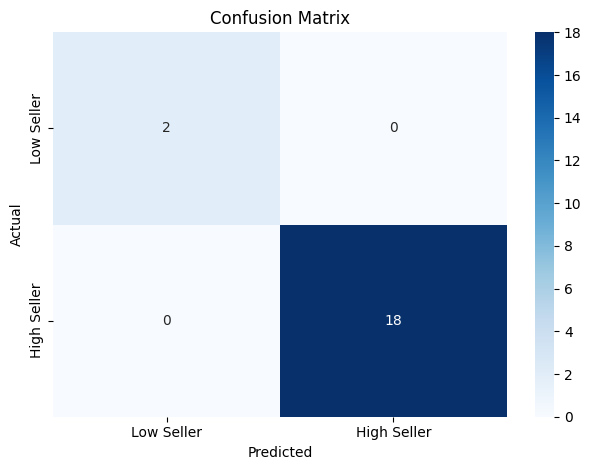

In [19]:
# Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include='number').columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Full model pipeline with LightGBM classifier
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(n_estimators=100, random_state=42))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)

print("\n‚úÖ Classification Report:\n")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Low Seller", "High Seller"],
            yticklabels=["Low Seller", "High Seller"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**Business Insights:**
- The model perfectly classified all high sellers (18/18) and low sellers (2/2) with no misclassifications.
- This indicates excellent model accuracy and reliable prediction of product performance.
- Recommendation: Deploy this model to support inventory planning, marketing focus, and restocking strategies.


### Production volumes, stock levels, and lead times Visualization.

In [31]:
from mpl_toolkits.mplot3d import Axes3D  # for 3D plots
# Drop missing values (only for visualization)
df_viz = df[['Production volumes', 'Stock levels', 'Lead time']].dropna()

#  2D Scatter Plot with Color = Lead Time
plt.figure(figsize=(9, 6))
sns.scatterplot(data=df_viz,
                x='Production volumes',
                y='Stock levels',
                hue='Lead time',
                palette='coolwarm',
                size='Lead time',
                sizes=(20, 200))
plt.title("Production Volumes vs Stock Levels (Color = Lead Time)")
plt.tight_layout()
plt.show()

### üì¶ Production Volumes
Average production volume: 567.84 units

Maximum: 985 units | Minimum: 104 units

Insight: There‚Äôs noticeable variability in production, suggesting flexibility in manufacturing capacity ‚Äî but it could also hint at inconsistent planning or fluctuating demand.

### üìà Stock Levels
Average stock level: 47.77 units

Maximum: 100 units | Minimum: 0 units

Insight: Many products are running low or at zero stock, which may reflect fast turnover or a risk of stockouts. Products with higher stock could lead to overproduction and higher holding costs.

### ‚è≥ Lead Times
Primary lead time average: 15.96 days (range: 1 to 30 days)

Manufacturing-specific lead time average: 17.08 days

Insight: Wide lead time variations could indicate inefficiencies in sourcing, production, or logistics. It may also reflect different suppliers or production sites with varying service levels.

### üöÄ Business Takeaways
Prioritize replenishing SKUs with critically low stock to prevent lost sales.

Negotiate with suppliers to shorten lead times, especially for best-selling products.

Implement better demand forecasting to align production with actual market needs.

Invest in quality control to reduce product defects and returns.

Review manufacturing and sourcing strategies to cut unnecessary costs.

Establish contingency plans for high-risk SKUs to safeguard against service disruptions.

## Visualization of Revenue distribution by location.

C:\Users\GHANESH\AppData\Local\Temp\ipykernel_16564\2949817886.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_viz.groupby('Location')['Revenue generated'].sum().reset_index(),


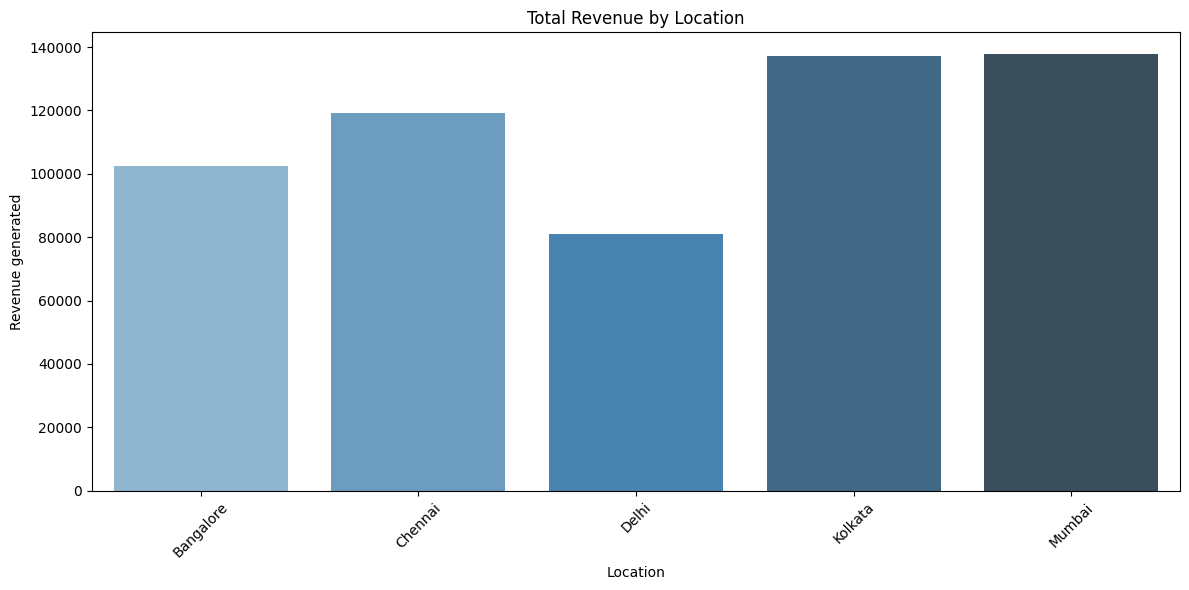

In [21]:
# Drop missing values in relevant columns
df_viz = df[['Location', 'Revenue generated']].dropna()

# Optional: convert location to string if it's numeric
df_viz['Location'] = df_viz['Location'].astype(str)

#  Total Revenue per Location ‚Äì Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_viz.groupby('Location')['Revenue generated'].sum().reset_index(),
            x='Location', y='Revenue generated', palette='Blues_d')
plt.title("Total Revenue by Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### üîç Key Insights
Top Performing Location:
Mumbai is the highest revenue generator, with a total revenue of $137,755.03.

Lowest Performing Location:
Delhi records the lowest total revenue at $81,027.70.

Revenue Distribution Observation:
Revenue is concentrated among specific locations, suggesting stronger customer bases, better logistics, or more effective marketing efforts in those areas.

### üöÄ Business Takeaways
Strengthen marketing and sales in top-performing areas like Mumbai to leverage the existing strong demand.

Investigate reasons behind the lower revenue in Delhi ‚Äî such as supply chain inefficiencies, lower market demand, or competitive pressures.

Adjust inventory and resource allocation dynamically based on location-specific sales data to avoid overstocking or stockouts.

Replicate successful strategies from Mumbai into lower-performing locations to stimulate growth.

Implement location-specific promotions or strategic partnerships to lift performance in weaker markets like Delhi.



## Visualization of Manufacturing costs by supplier.

In [22]:
# Replace 'Location' with the actual supplier column if needed
df_viz = df[['Location', 'Manufacturing costs']].dropna()
df_viz['Location'] = df_viz['Location'].astype(str)

#  Barplot: Average manufacturing cost by supplier
plt.figure(figsize=(12, 6))
avg_costs = df_viz.groupby('Location')['Manufacturing costs'].mean().reset_index()
sns.barplot(data=avg_costs, x='Location', y='Manufacturing costs', palette='coolwarm')
plt.title("Average Manufacturing Costs by Supplier (Location)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\GHANESH\AppData\Local\Temp\ipykernel_16564\4221826215.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_costs, x='Location', y='Manufacturing costs', palette='coolwarm')


### üîç Key Insights
Bangalore has the highest manufacturing costs, averaging around $62.

Mumbai has the lowest manufacturing costs, averaging around $37.

Cost Gradient Observation:
There's a clear cost decline from Bangalore ‚Üí Chennai ‚Üí Delhi ‚Üí Kolkata ‚Üí Mumbai.
This suggests that manufacturing costs vary significantly by region, likely due to differences in labor costs, logistics, taxes, and supplier efficiencies.

### üöÄ Business Takeaways
Shift more production to Mumbai and Kolkata, where manufacturing costs are significantly lower.

Limit or negotiate contracts with suppliers in Bangalore unless they offer other major advantages (e.g., faster delivery, superior quality).

Analyze what drives higher costs in Bangalore ‚Äî is it labor, transportation, or other operational expenses? If possible, restructure supply chain routes to bypass these high-cost centers.

Diversify manufacturing footprints into lower-cost regions like Mumbai and Kolkata to mitigate financial risks and improve margins.

Use regional cost benchmarking during supplier negotiations to push for better pricing terms across all locations

## Visualization of Comparison of price and manufacturing costs by product type.

In [23]:
# Keep only relevant columns and drop missing values
df_viz = df[['Product type', 'Price', 'Manufacturing costs']].dropna()

# Aggregate: Average Price and Manufacturing Cost per Product Type
df_grouped = df_viz.groupby('Product type').agg({
    'Price': 'mean',
    'Manufacturing costs': 'mean'
}).reset_index()

# Melt for easier plotting
df_melted = df_grouped.melt(id_vars='Product type',
                            value_vars=['Price', 'Manufacturing costs'],
                            var_name='Metric',
                            value_name='Amount')

# Plot: Side-by-side bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='Product type', y='Amount', hue='Metric')
plt.title('Comparison of Price vs Manufacturing Costs by Product Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### üîç Key Insights
Cosmetics:
The price is significantly higher than the manufacturing cost, suggesting strong profit margins in this product category.

Haircare:
Manufacturing cost slightly exceeds the price, indicating very tight or negative margins ‚Äî a serious profitability concern.

Skincare:
Similarly, manufacturing costs are slightly higher than the price, again highlighting low or negative margins for skincare products.

General Observation:
Only cosmetics seem to be generating healthy margins, while haircare and skincare are either breaking even or losing money after manufacturing costs alone (not even accounting for shipping, marketing, or operational costs).

### üöÄ Business Takeaways
Focus on scaling cosmetics ‚Äî it's currently your most profitable product line.

Review pricing strategies for haircare and skincare ‚Äî consider price adjustments or premium positioning if market demand allows.

Reduce manufacturing costs for haircare and skincare through supplier renegotiations, bulk procurement, or production efficiency improvements.

Analyze customer willingness to pay ‚Äî if haircare and skincare products have strong customer loyalty or perceived value, price hikes could be feasible.

Consider product bundling (e.g., combine skincare and cosmetics) to increase effective selling prices while offering customer value.

Monitor margin trends closely to ensure long-term sustainability ‚Äî margins this tight can become critical quickly if costs rise further.

## Visualization of Relationship between production volume, stock levels, and order quantities.

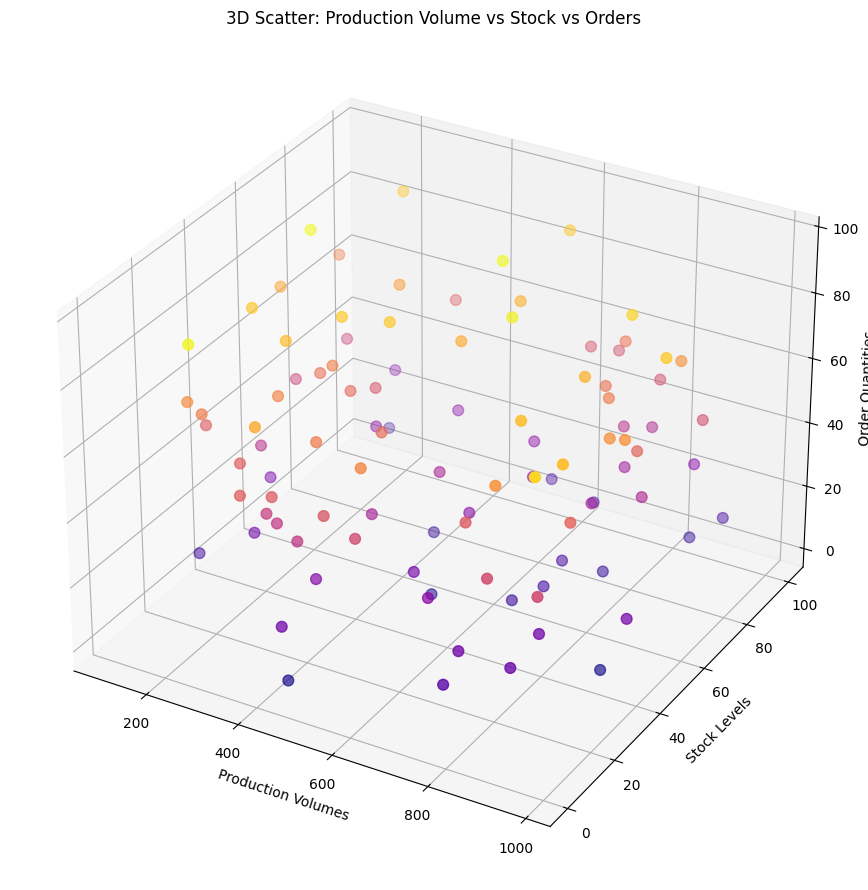

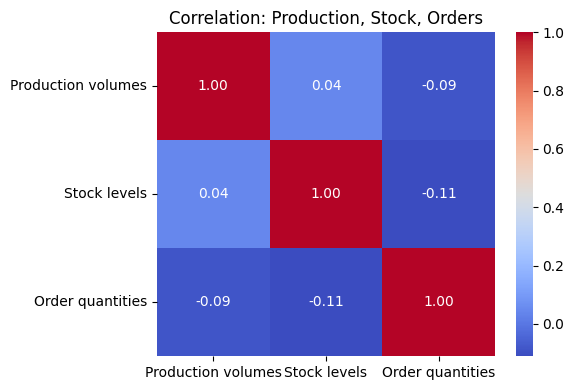

In [30]:
# Drop missing values for the 3 key columns
df_viz = df[['Production volumes', 'Stock levels', 'Order quantities']].dropna()

# 1Ô∏è‚É£ 3D Scatter Plot
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    df_viz['Production volumes'],
    df_viz['Stock levels'],
    df_viz['Order quantities'],
    c=df_viz['Order quantities'],
    cmap='plasma',
    s=60
)
ax.set_xlabel('Production Volumes')
ax.set_ylabel('Stock Levels')
ax.set_zlabel('Order Quantities')
ax.set_title('3D Scatter: Production Volume vs Stock vs Orders')
plt.tight_layout()
plt.show()

# 2Ô∏è‚É£ Correlation Heatmap
plt.figure(figsize=(6, 4))
corr = df_viz.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation: Production, Stock, Orders")
plt.tight_layout()
plt.show()



**Business Insights:**
- Weak correlations suggest production, stock, and orders are poorly synchronized.
- Stock levels slightly decrease when order quantities rise (correlation = -0.11).
- Risk of overproduction or stockouts due to low production-stock linkage.
- Recommendation: Align production closer to demand, improve inventory visibility, and optimize logistics to reduce costs and lead times.


## Distribution of shipping costs by shipping carriers.

<Figure size 1000x600 with 0 Axes>

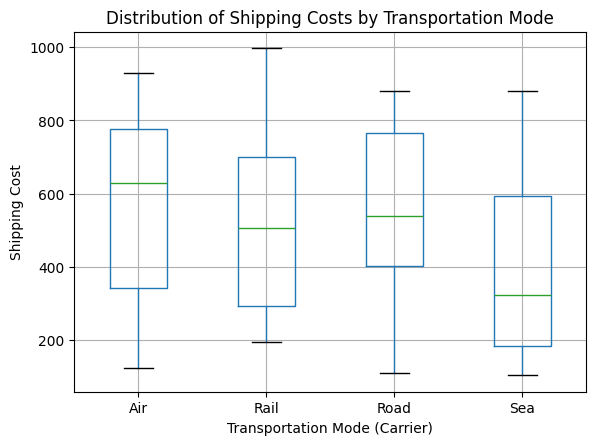

In [25]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create boxplot of shipping costs by transportation mode (carrier)
df.boxplot(column='Costs', by='Transportation modes')

# Customize plot
plt.title('Distribution of Shipping Costs by Transportation Mode')
plt.suptitle('')  # Remove default subtitle
plt.xlabel('Transportation Mode (Carrier)')
plt.ylabel('Shipping Cost')
plt.grid(True)

# Show plot
plt.show()

**Business Insights:**
- Air and Road have the highest shipping cost variability; Air is the most expensive on average.
- Rail offers moderate costs with relatively balanced spread.
- Sea is the most cost-effective but has high variability.
- Recommendation: Use Sea for non-urgent shipments and prioritize Rail for cost control on urgent deliveries.


## Average lead time by product type.

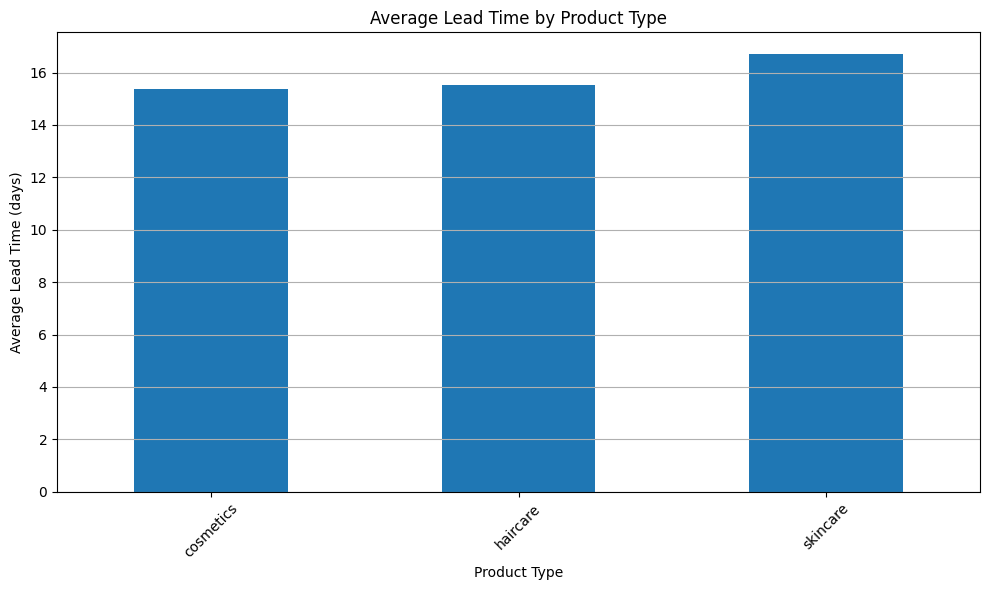

In [26]:
# Group by product type and calculate average lead time
avg_lead_time = df.groupby('Product type')['Lead times'].mean().sort_values()

# Plot the average lead time
plt.figure(figsize=(10, 6))
avg_lead_time.plot(kind='bar')

# Customize plot
plt.title('Average Lead Time by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Average Lead Time (days)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show plot
plt.tight_layout()
plt.show()

**Business Insights:**
- Skincare products have the longest average lead time (~17 days), followed by haircare and cosmetics (~15.5 days).
- Higher lead times for skincare could impact stock availability and customer satisfaction.
- Recommendation: Focus on reducing skincare supply chain delays to improve responsiveness and inventory turnover.


## Transportation routes and their frequency.

In [27]:
# Count transportation mode frequency
mode_counts = df['Transportation modes'].value_counts()

# Plot the frequencies
plt.figure(figsize=(8, 6))
mode_counts.plot(kind='bar')

# Customize the plot
plt.title('Frequency of Transportation Modes')
plt.xlabel('Transportation Mode')
plt.ylabel('Number of Shipments')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.tight_layout()
plt.show()


**Business Insights:**
- Road and Rail are the most frequently used transportation modes, indicating reliance on land transport.
- Air is moderately used despite higher costs, suggesting urgency for some shipments.
- Sea is least utilized, possibly due to longer delivery times.
- Recommendation: Explore greater use of Sea transport for non-urgent shipments to optimize logistics costs.


## Supply chain risk distribution by risk factors

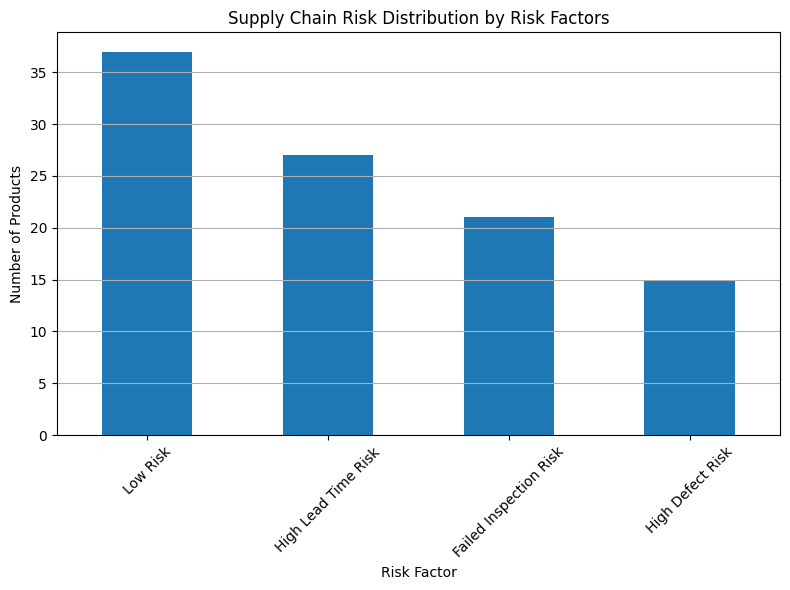

In [28]:

# Create a 'Risk Factor' column based on conditions
def categorize_risk(row):
    if row['Defect rates'] > 4.0:
        return 'High Defect Risk'
    elif row['Lead times'] > 20:
        return 'High Lead Time Risk'
    elif row['Inspection results'] == 'Fail':
        return 'Failed Inspection Risk'
    else:
        return 'Low Risk'

df['Risk Factor'] = df.apply(categorize_risk, axis=1)

# Count risk categories
risk_counts = df['Risk Factor'].value_counts()

# Plot risk distribution
plt.figure(figsize=(8, 6))
risk_counts.plot(kind='bar')

# Customize plot
plt.title('Supply Chain Risk Distribution by Risk Factors')
plt.xlabel('Risk Factor')
plt.ylabel('Number of Products')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Business Insights:**
- Majority of products are classified as Low Risk, indicating overall supply chain stability.
- High Lead Time Risk and Failed Inspection Risk are notable concerns affecting a significant share.
- High Defect Risk, while lower in count, still poses potential quality and cost challenges.
- Recommendation: Prioritize actions to reduce lead times and improve inspection processes for risk mitigation.


## Sustainability factors in the supply chain.

In [29]:

# Define a sustainability scoring function
def sustainability_score(row):
    if row['Transportation modes'] == 'Air':
        return 'High Carbon Emission'
    elif row['Transportation modes'] == 'Rail':
        return 'Low Carbon Emission'
    elif row['Transportation modes'] == 'Road':
        return 'Medium Carbon Emission'
    else:
        return 'Unknown'

# Apply sustainability categorization
df['Sustainability Factor'] = df.apply(sustainability_score, axis=1)

# Count sustainability categories
sustainability_counts = df['Sustainability Factor'].value_counts()

# Plot the sustainability distribution
plt.figure(figsize=(8, 6))
sustainability_counts.plot(kind='bar')

# Customize plot
plt.title('Sustainability Factors in the Supply Chain')
plt.xlabel('Sustainability Category')
plt.ylabel('Number of Shipments')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.tight_layout()
plt.show()

**Business Insights:**
- Most shipments fall into Medium and Low Carbon Emission categories, showing a moderate sustainability focus.
- High Carbon Emission shipments are still significant and present opportunities for greener alternatives.
- The 'Unknown' category indicates data gaps that could impact sustainability reporting.
- Recommendation: Reduce high-emission shipments and improve data capture for better environmental impact tracking.


|Area                         | Action Steps
|----------------------------|----------------------------------------------------|
|Reduce High Carbon Shipments | Limit air usage for urgent cargo only              |
|Enhance Low Carbon Options   | Increase rail usage where possible                 |
|Optimize Road Logistics      | Implement smart routing, EV trucks                 |
|Data Quality Improvement     | Enforce mandatory transportation mode documentation|
|Sustainability Reporting     | Highlight low-carbon achievements in CSR reports   |

In [34]:
# Install LightGBM if not already installed
# !pip install lightgbm

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

# Load data
df =pd.read_csv(r'C:\Users\GHANESH\Downloads\supply_chain_data.csv')

# Target variable
y = df['Number of products sold']

# Selecting only important features for demand
selected_features = [
    'Price', 'Availability', 'Stock levels', 'Lead times', 'Order quantities',
    'Shipping costs', 'Production volumes', 'Manufacturing costs', 'Defect rates', 'Costs'
]

X = df[selected_features]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Pipeline: StandardScaler + LightGBM
model = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale features for better learning
    ('regressor', LGBMRegressor(n_estimators=150, learning_rate=0.05, random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n‚úÖ Improved Model Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R¬≤ Score: {r2:.2f}")

# Plot: True vs Predicted
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.xlabel("Actual Number of Products Sold")
plt.ylabel("Predicted Number of Products Sold")
plt.title("Actual vs Predicted Sales")
plt.grid(True)
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 268
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 10
[LightGBM] [Info] Start training from score 453.200000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\GHANESH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
